Description:
Train basic neural net on the MNIST data set without using any features from these models; 
Will initially only use the most basic PyTorch tensor functionality. 
Then, will incrementally add one feature from torch.nn, torch.optim, Dataset, or DataLoader at a time, 
Showing exactly what each piece does.

In [1]:
# MNIST data setup

from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


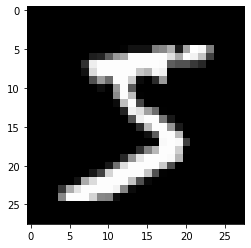

In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [4]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [5]:
# Neural net form scratch

import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

yb  = y_train[0:bs]
print(loss_func(preds, yb))

# Accuracy
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(accuracy(preds, yb))

tensor([-2.0099, -2.2301, -2.2727, -2.6497, -2.6003, -2.2398, -2.2791, -1.9096,
        -2.3007, -2.9310], grad_fn=<SelectBackward0>) torch.Size([64, 10])
tensor(2.2966, grad_fn=<NegBackward0>)
tensor(0.1562)


In [6]:
# Train Loop, with torch.no_grad() and set gradients to 0
from IPython.core.debugger import set_trace

lr = 0.5 # learning rate
epochs = 2 # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        # set_trace
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0799, grad_fn=<NegBackward0>) tensor(1.)


In [7]:
# Refactor
# nn.functional

import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0799, grad_fn=<NllLossBackward0>) tensor(1.)


In [8]:
# nn.Module

from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    
    def forward(self, xb):
        return xb @ self.weights + self.bias

model = Mnist_Logistic()

print(loss_func(model(xb), yb))

tensor(2.3786, grad_fn=<NllLossBackward0>)


In [9]:
# Optim grdient update

def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
fit()

print(loss_func(model(xb), yb))

tensor(0.0805, grad_fn=<NllLossBackward0>)


In [10]:
# Refactor using nn.Linear

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)
    
    def forward(self, xb):
        return self.linear(xb)

model = Mnist_Logistic()
print(loss_func(model(xb), yb))

fit()

print(loss_func(model(xb), yb))

tensor(2.3756, grad_fn=<NllLossBackward0>)
tensor(0.0820, grad_fn=<NllLossBackward0>)


In [11]:
# Refactor using optim

"""
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
    
# instead use:

opt.step()
opt.zero_grad()
"""

from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3139, grad_fn=<NllLossBackward0>)
tensor(0.0819, grad_fn=<NllLossBackward0>)


In [12]:
# Refactor using Dataset

from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)

model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs : i * bs + bs]    # Replace start_i , end_i with train_ds
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0827, grad_fn=<NllLossBackward0>)


In [13]:
# Refactor using DataLoader

from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0829, grad_fn=<NllLossBackward0>)


In [14]:
# Add validation
# Shuffling

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

# (Note that we always call model.train() before training, and model.eval() before inference, 
# because these are used by layers such as nn.BatchNorm2d and nn.Dropout to ensure appropriate behaviour 
# for these different phases.)

model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3160)
1 tensor(0.3211)


In [15]:
# Create fit() and get_data()
# We’ll now do a little refactoring of our own. 
# Since we go through a similar process twice of calculating the loss for both the training set and the validation set, 
# let’s make that into its own function, loss_batch, which computes the loss for one batch.
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(xb)

# fit
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        print(epoch, val_loss)

# get data from DataLoader
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

# can use these basic 3 lines of code to train a wide variety of models
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.2870591865181923
1 0.29124527857303617


In [16]:
# Switch to CNN
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3903261641740799
1 0.24754363058805465


In [17]:
# nn.Sequential
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    
    def forward(self, x):
        return self.func(x)

def preprocess(x):
        return x.view(-1, 1, 28, 28)

model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1))
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.46416413869857787
1 0.25649237793684004


In [18]:
# Wrapping DataLoader / more adaptive for input

# Replace reshpe in Module with Dataloader preprocess
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3766436596870422
1 0.2577061900258064


In [25]:
# GPU
# ??? Why GPU utilization is 0 at the begining, then come to zero for other epochs?

print(torch.cuda.is_available())

dev = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(dev)

def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

True
cuda:0
0 0.12036010765697938
1 0.13989684531146376
